In [16]:
# pip install transformers
# pip install seqeval
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install seaborn
# !pip install scikit-learn
# !pip install torch torchvision
# !pip install nltk
# !pip install  spacy
# !pip install scipy
# !pip install yellowbrick
# !pip install tqdm
# !pip install openpyxl
# !pip install nlpaug

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split, Dataset

In [50]:
path="final data.xlsx"
data=pd.read_excel(path)
data.sample(10)

,sentence,intent
285,Can you please form an 'ASSOCIATED_WITH' relat...,add relationship
207,"Add the property 'skills: ['C#', 'SQL Server',...",add property
273,I need to establish a 'SIMILAR_TO' relationshi...,add relationship
225,"Add the property 'skills: ['SQL', 'Excel', 'Da...",add property
152,"Get rid of this node, I don't want it anymore!",delete node
2,I would like to add a node labeled 'Game'.,add node
235,I want to establish a 'MENTORS' relationship b...,add relationship
247,I would like to add a 'MEMBER_OF' relationship...,add relationship
272,Is it possible to add a 'LOCATED_IN' relations...,add relationship
122,Delete the node corresponding to the correlati...,delete node


In [19]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

### DATA EXPLORATION

In [20]:
print("Total number of instances:")
print(len(data))

Total number of instances:
314


Text(0.5, 1.0, 'Distribution of data among classes in dataset.')

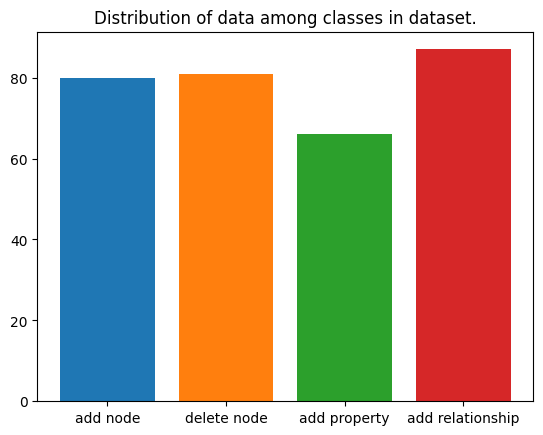

In [21]:
classes=data['intent'].unique()
countDict={}
for Class in classes:
    countDict[Class]=data['intent'].value_counts().get(Class,0)
for Class,count in countDict.items():
    plt.bar(Class,count)
plt.title('Distribution of data among classes in dataset.')

Since the distribution of data among the classes is not too imbalanced, we do not need to perform normalization. 

Exploring the variation of lengths of input data to determine a sequence length that our model will work with.

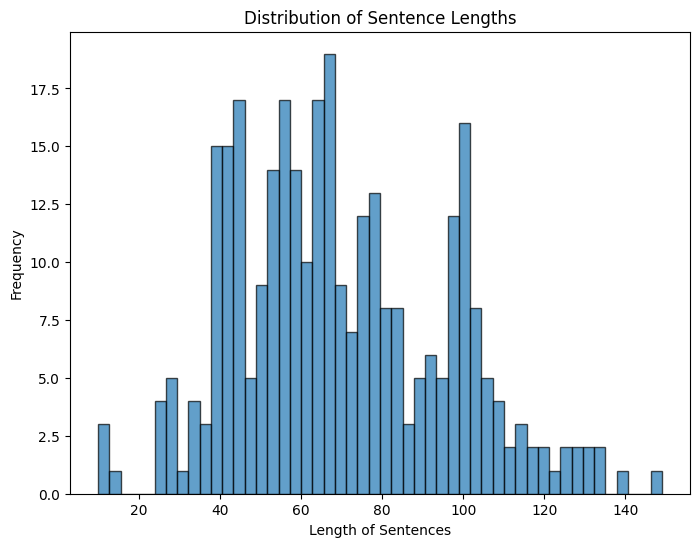

In [65]:
lengths=[]
for sentence in data['sentence']:
    lengths.append(len(sentence))
plt.figure(figsize=(8, 6))
plt.hist(lengths,bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.show()

### DATA PRE-PROCESSING

As BERT is trained on a corpus of full sentences of natural language and the embedding process involves contextual embedding, performing stop-word removal might interfere with the accurate functioning of BERT. So we do not remove stop words from our input. This is also why we will not be performing stemming or lemmatization.

removing all punctuation marks except '' and "" as the specifics of graph manipulation are expected to be input in quotes.

In [22]:
import string
def removePunctuation(sentence):
    cleaned="".join([char for char in sentence if char not in string.punctuation or char=="'" or char=='"'])    
    return cleaned

In [23]:
data['sentence'] =data['sentence'].apply(removePunctuation) #remove punctuation from data

convert all classes to numerical classes <br>

In [24]:
ClassNumber=1
for Class in data['intent'].unique():
    print(f'Class name:{Class}-->number: {ClassNumber}')
    data['intent']=data['intent'].replace(Class,ClassNumber)
    ClassNumber+=1

Class name:add node-->number: 1
Class name:delete node-->number: 2
Class name:add property-->number: 3
Class name:add relationship-->number: 4


C:\Users\z004z4ut\AppData\Local\Temp\ipykernel_5220\2149787421.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['intent']=data['intent'].replace(Class,ClassNumber)


In [31]:
data.sample(10)

,sentence,intent
25,Please add a 'Club' node,1
269,I need to establish a 'CONTAINS' relationship ...,4
76,Create a node for the scientific discovery 'Pe...,1
261,I would like to add a 'PUBLISHEDIN' relationsh...,4
61,create node,1
221,Create a node with the property 'name Grace' '...,3
161,Include the property 'met at ACME Conference' ...,3
280,Is it possible to add a 'LOCATEDIN' relationsh...,4
131,Please remove the node with ID 1234,2
113,Delete the node representing the measurement w...,2


**PRE-PROCESSING FOR BERT** <br>
1. [CLS] and [SEP] are special tokens that BERT requires. this is because BERT was orginally trained for Q-A tasks. For classfn tasks, BERT requires another special token. All of these tokens are in-built in the hugging face tokenizer. 
2. All sequences must be of the same length, so we need to do padding. We do the padding on the right side which is preferred for BERT.
3. Finally we pass in attention mask to assign importance to each token. So all non-padding tokens are assigned an attention of 1 and padding tokens 0.
<br><br>
<i>Since BERT takes the input ids, attention mask and target classes as 3 separate outputs, we can create a dataset where each of them are a separate column to make our program more readable.<i>

Hugging face's BERT tokenizer uses pre trained BERT base, a small version of BERT. we use cased BERT because we want our model to be case sensitive, which will be important for paramter extraction in the named entity recognition layer.

In [26]:
def preProcess(data):
    tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
    input_ids_list=[]
    attention_masks_list=[]
    intents_list=[]
    for sentence,label in zip(data['sentence'],data['intent']):
        encoding=tokenizer.encode_plus(
            sentence,
            add_special_tokens= True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt' #pt signifies pyTorch, use tf for tensorFlow & keras
        )
        input_ids_list.append(encoding['input_ids'])
        attention_masks_list.append(encoding['attention_mask'])
        intents_list.append(torch.tensor(label).long()) #most transformer models and BERT expect input data to be of the type LongTensor
    #to ensure that all of our tensors have the same shape we use cat()
    input_ids_list = torch.cat(input_ids_list)
    attention_masks_list = torch.cat(attention_masks_list)
    intents_list = torch.stack(intents_list)
    dataset=TensorDataset(input_ids_list,attention_masks_list,intents_list)
    return dataset

In [27]:
dataset=preProcess(data)

In [57]:
for i in range(1):
    input_ids, attention_mask, intent = dataset[i]
    print(f"Input IDs: {input_ids}")
    print(f"Attention Mask: {attention_mask}")
    print(f"Intent: {intent}")
    print()

Input IDs: tensor([  101,  4203,  5194,   170,   112,  3168,   112, 14372,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

### TRAINING AND MODEL ARCHITECTURE

Creating train and test sets with mydataset and dataloader

In [45]:
train_percent=0.8
test_percent=0.2
train_data,test_data=random_split(dataset,[train_percent,test_percent])

In [49]:
#we do not have to define custom dataset with Dataset class as we've used TensorDataset() on our data.
bSize=4
trainingData=DataLoader(train_data,batch_size=bSize,shuffle=True)
testingData=DataLoader(test_data,batch_size=bSize,shuffle=True)

Define model architecture